## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from tqdm import tqdm_notebook as tqdm
import os
import urllib
import requests
import tarfile
import glob
from collections import defaultdict
import cv2

%matplotlib inline

/home/maciej/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/maciej/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Some useful methods

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')
    return dict_


def hog_feature_extraction(data):
    data_hog = []
    hog = cv2.HOGDescriptor(_winSize=(32, 32), 
                            _blockSize=(16, 16),
                            _blockStride=(8, 8),
                            _cellSize=(8, 8), 
                            _nbins=9)
    for image in data:
        data_hog.append(np.hstack(hog.compute(np.transpose(image, (1, 2, 0))
                                              .astype('uint8'))))
    return data_hog


def norm_data(data):
    mean = np.mean(data, axis=0)
    std =  np.std(data, axis=0)
    std[std == 0] = 1
    data = (data - mean) / std
    return data


def threshold(vec, value):
    for i in range(len(vec)):
        if vec[i] >= value:
            vec[i] = 1
        else:
            vec[i] = 0
    return vec.astype(int)


def acc(y_correct, y_pred):
    acc = 0
    for i in range(len(y_pred)):
        acc += y_pred[i] == y_correct[i]
    
    return acc / len(y_pred)

## Download files

In [3]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
filename = url.rsplit("/", maxsplit=1)[-1]
r = requests.get(url, stream=True)
total_size = int(r.headers.get('content-length', 0)); 

with open(filename, 'wb') as f:
    for data in tqdm(r.iter_content(), total=total_size, unit='B', unit_scale=True):
        f.write(data)

## Unzip them

In [4]:
with tarfile.open(filename) as tar_file:
    directory = os.path.commonprefix(tar_file.getnames())
    tar_file.extractall()

In [5]:
X_train, y_train = [], []
for training_file in glob.glob("%s/data_batch_*" % directory):
    batch = unpickle(training_file) 
    X_train.append(batch[b'data'])
    y_train.append(batch[b'labels'])
    
X_train = np.concatenate(X_train).reshape(-1, 3, 32, 32).astype(np.float32)
y_train = np.concatenate(y_train).astype(np.int32)

test_file = unpickle("%s/test_batch" % directory)
X_test = test_file[b'data'].reshape(-1, 3, 32, 32).astype(np.float32)
y_test = np.array(test_file[b'labels'], dtype=np.int32)

## Plot images

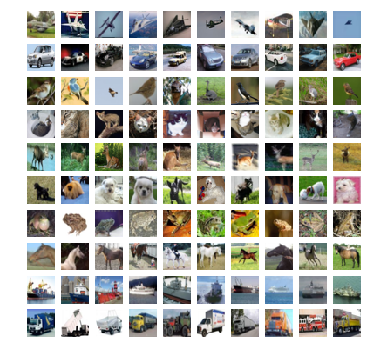

In [4]:
classes = defaultdict(list)
for img, class_ in zip(X_train, y_train):
    classes[class_].append(img)

fig, axes = plt.subplots(10, 10, figsize=(6, 6))
for j in range(10):
    for k in range(10):
        images = classes[j]
        i = np.random.choice(range(len(images)))
        axes[j][k].set_axis_off()
        axes[j][k].imshow(np.transpose(images[i], (1, 2, 0)).astype('uint8'), 
                          interpolation='nearest')

## Benchmark

In [58]:
X_train_hog = hog_feature_extraction(X_train)
X_train_hog = np.array(X_train_hog)

X_test_hog = hog_feature_extraction(X_test)
X_test_hog = np.array(X_test_hog)

In [61]:
svc = LinearSVC()

print("--- Start training")
svc.fit(X_train_hog, y_train)
print("--- SVM prediction on the test set")
y_pred = svc.predict(X_test_hog)

print("SVM: we got results: ACC: %.2f, F1: %.2f" % 
      (acc(y_test, y_pred), f1_score(y_test, y_pred, average='micro')))

--- Start training
--- SVM prediction on the test set
SVM: we got results: ACC: 0.54, F1: 0.54


## Extract visual features

### Preprocessing

In [ ]:
X_train[:, 0, :, :] -= 103.939
X_train[:, 1, :, :] -= 116.779
X_train[:, 2, :, :] -= 123.68

### VGG16

In [7]:
from vgg16_keras import preprocessing_image, VGG_16
from keras.optimizers import SGD

model = VGG_16(weights_path="vgg16_weights.h5", init_shape=(3, 224, 224))

img = cv2.resize(cv2.imread("elephant.jpg"), (224, 224)).astype(np.float32)
print(img.shape)
img = preprocessing_image(img)
print(img.shape)

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

ValueError: The shape of the input to "Flatten" is not fully defined (got (0, 7, 512). Make sure to pass a complete "input_shape" or "batch_input_shape" argument to the first layer in your model.